## Implementación de detectores de objetos en Keras

In [45]:
import PIL as pl
import numpy as np
import tensorflow as tf
from tensorflow import keras


from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt


In [2]:
bbtr=open('C:/Users/Jose Giner/OneDrive/Escritorio/AIV/Practica 2/dataset_motorbikes/dataset_motorbikes/bb/training.bb').read().strip().split("\n")
training_bb=[]
training_data=[]
for line in bbtr:
    (fn, t, b, l, r)=line.split(" ")
    aux=pl.Image.open("C:/Users/Jose Giner/OneDrive/Escritorio/AIV/Practica 2/dataset_motorbikes/dataset_motorbikes/images/training/"+fn+".jpg")
    training_bb.append((float(t)/aux.size[1], float(b)/aux.size[1], float(l)/aux.size[0], float(r)/aux.size[0]))
    fitaux=aux.resize((224, 224))
    training_data.append(img_to_array(fitaux))
training_bb = np.array(training_bb, dtype="float32")
training_data = np.array(training_data, dtype="float32") / 255.0

In [3]:
bbval=open('C:/Users/Jose Giner/OneDrive/Escritorio/AIV/Practica 2/dataset_motorbikes/dataset_motorbikes/bb/validation.bb').read().strip().split("\n")
validation_bb=[]
validation_data=[]
for line in bbval:
    (fn, t, b, l, r)=line.split(" ")
    aux=pl.Image.open("C:/Users/Jose Giner/OneDrive/Escritorio/AIV/Practica 2/dataset_motorbikes/dataset_motorbikes/images/validation/"+fn+".jpg")
    validation_bb.append((float(t)/aux.size[1], float(b)/aux.size[1], float(l)/aux.size[0], float(r)/aux.size[0]))
    fitaux=aux.resize((224, 224))
    validation_data.append(img_to_array(fitaux))
validation_bb = np.array(validation_bb, dtype="float32")
validation_data = np.array(validation_data, dtype="float32") / 255.0

In [4]:
bbte=open('C:/Users/Jose Giner/OneDrive/Escritorio/AIV/Practica 2/dataset_motorbikes/dataset_motorbikes/bb/test.bb').read().strip().split("\n")
test_bb=[]
test_data=[]
test_image=[]
test_image_fit=[]
for line in bbte:
    (fn, t, b, l, r)=line.split(" ")
    aux=pl.Image.open("C:/Users/Jose Giner/OneDrive/Escritorio/AIV/Practica 2/dataset_motorbikes/dataset_motorbikes/images/test/"+fn+".jpg")
    test_image.append(aux)
    test_bb.append((float(t)/aux.size[1], float(b)/aux.size[1], float(l)/aux.size[0], float(r)/aux.size[0]))
    fitaux=aux.resize((224, 224))
    test_image_fit.append(fitaux)
    test_data.append(img_to_array(fitaux))
test_bb = np.array(test_bb, dtype="float32")
test_data = np.array(test_data, dtype="float32") / 255.0

### VGG-16

Primero utilizaremos la arquitectura de VGG-16 para aplicar el transfer learning y crear unas capas densas para detectar los limites de la caja de inclusión mínima, por lo que habrán 4 nodos en la capa de salida.

In [5]:
def create_model(input_shape, optimizer, loss_criterion, fine_tune=0):
    """
    Compila un modelo entrenado con las capas de VGG-16
    
    input_shape: tupla - tamaño de las imágenes de entrada en forma (width, height, channels)
    optimizer: string - optimizador a utilizar en el entrenamiento para la actualización de pesos en el proceso de backpropagation'
    loss_criterion: string - función de pérdida para medir el rendimiento de la red
    fine_tune: int - Número de capas del modelo preentrenado a entrenar.
                Si es 0, todas las capas preentrenadas se 'congelan' en el entrenamiento
    """
    
    # Las capas preentrenadas utilizan en este caso pesos del dataset de imagenet.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    model_pre = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in model_pre.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in model_pre.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = model_pre.output
    x = keras.layers.Flatten()(top_model)
    x = keras.layers.Dense(128, activation="relu")(x)
    x = keras.layers.Dense(64, activation="relu")(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    output_layer = keras.layers.Dense(4, activation="sigmoid")(x)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=model_pre.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss=loss_criterion)
    
    return model

Primera configuración: Adam con lr = 0.0001, MSE como función de pérdida y sin fine-tuning (todas las capas del modelo salvo las que hemos definido congeladas).

In [6]:
input_shape = (224, 224, 3)
optim_1 =  tf.keras.optimizers.Adam(learning_rate=0.0001)
criterion1 = 'mse'
BATCH_SIZE = 32
n_epochs = 10


n_steps = len(training_data) // BATCH_SIZE
n_val_steps = len(validation_data) // BATCH_SIZE


vgg16_model = create_model(input_shape, optim_1, criterion1, fine_tune=0)

Obtenemos información sobre las capas del modelo preentrenado:

In [26]:
vgg16_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [7]:
from livelossplot.tf_keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='det_model_v1.weights.best.vgg16',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,
                           mode='min')

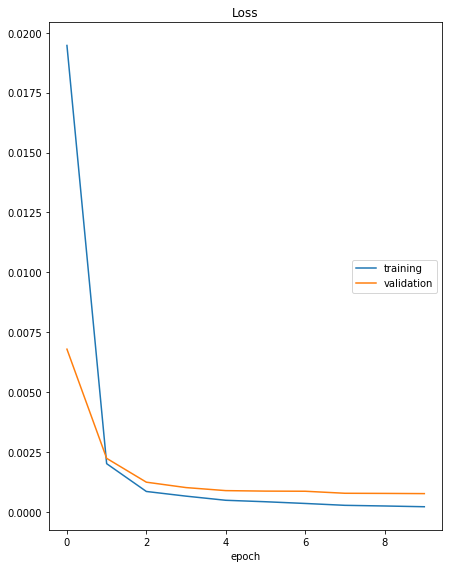

Loss
	training         	 (min:    0.000, max:    0.019, cur:    0.000)
	validation       	 (min:    0.001, max:    0.007, cur:    0.001)
18/18 [==============================] - 78s 4s/step - loss: 2.2011e-04 - val_loss: 7.6777e-04


In [11]:
vgg_history = vgg16_model.fit(training_data, 
                            training_bb, 
                            validation_data=(validation_data, validation_bb),
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)  
                                                        

In [8]:
import matplotlib.pyplot as plt
vgg16_model.load_weights('det_model_v1.weights.best.vgg16') 


Mostramos las predicciones

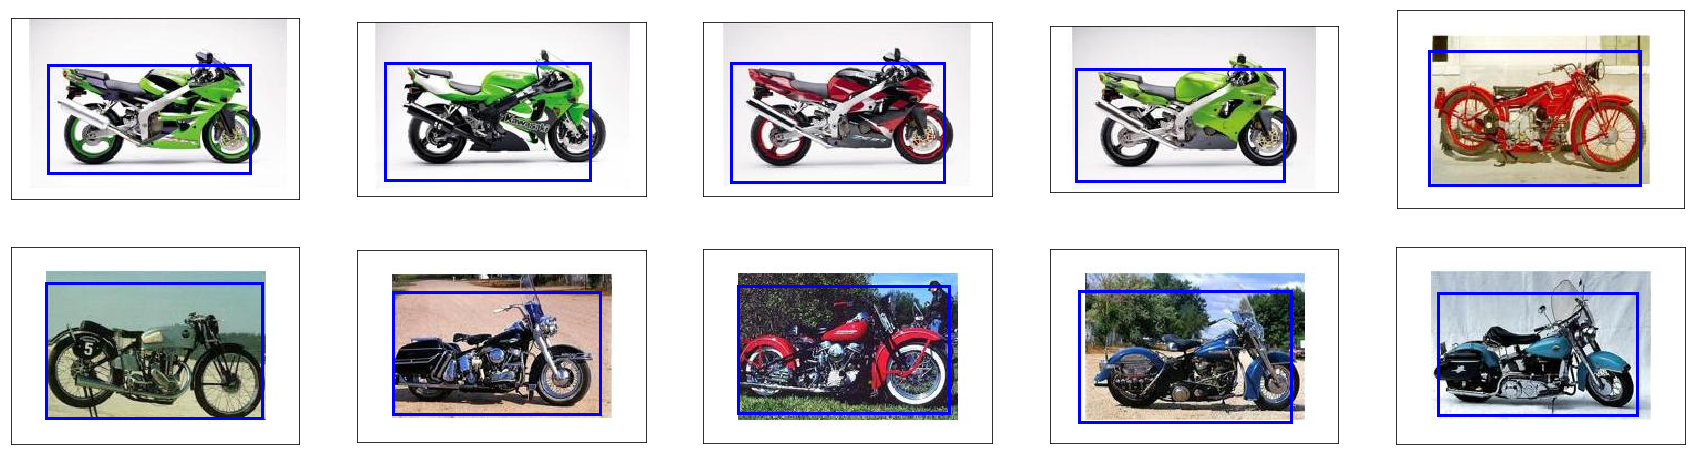

In [9]:
from matplotlib.patches import Rectangle
fig = plt.figure(figsize=(30, 8))
for i in range(10):
    
    test_array = np.expand_dims(test_data[i], axis=0)
    (tt, tb, tl, tr) = vgg16_model.predict(test_array)[0]
     
    im = img_to_array(test_image[i])
    tti = int(tt*im.shape[0])
    tbi = int(tb*im.shape[0])
    tli = int(tl*im.shape[1])
    tri = int(tr*im.shape[1])
    
    test_img_bb=im
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    boxA = Rectangle((tti, tli),
    tri - tli,
    tbi - tti,
    linewidth=3, edgecolor='b', facecolor='none')

    ax.add_patch(boxA)
    plt.imshow(np.uint8(test_img_bb))


Mostramos métricas para evaluar las predicciones de nuestra red, entre ellas el MSE, MAE, MAPE, RMSE y la intersección sobre la unión media de todas las imagenes del conjunto de test. Destacar que los valores de los límites de las cajas tanto las predichas como las reales están normalizados entre 0 y 1 por lo que los errores medios mostrados a continuación no corresponden a distancias en la imagen original.

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

results = {'Modelo': [], 'MSE':[], 'MAE':[], 'MAPE':[], 'RMSE':[], 'Mean IOU':[]}
preds = vgg16_model.predict(test_data)
results['Modelo'].append('VGG16-Adam(lr = 0.0001)-mse-ft0')
results['MSE'].append(mean_squared_error(test_bb,preds))
results['MAE'].append(mean_absolute_error(test_bb,preds))
results['MAPE'].append(mean_absolute_percentage_error(test_bb,preds))
results['RMSE'].append(mean_squared_error(test_bb,preds, squared=False))

area_caja_real = (test_bb[:,1] - test_bb[:,0]) * (test_bb[:,3] - test_bb[:,2])
area_caja_predicha = (preds[:,1] - preds[:,0]) * (preds[:,3] - preds[:,2])

xA = np.array([max(p,r) for p,r in zip(preds[:,0], test_bb[:,0])])
yA = np.array([max(p,r) for p,r in zip(preds[:,2], test_bb[:,2])])

xB = np.array([min(p,r) for p,r in zip(preds[:,1], test_bb[:,1])])
yB = np.array([min(p,r) for p,r in zip(preds[:,3], test_bb[:,3])])

interArea = (xB - xA) * (yB - yA)
iou = interArea/(area_caja_real+area_caja_predicha-interArea)
results['Mean IOU'].append(np.mean(iou))

In [11]:
results

{'Modelo': ['VGG16-Adam(lr = 0.0001)-mse-ft0'],
 'MSE': [0.000931419],
 'MAE': [0.020630354],
 'MAPE': [0.07886897],
 'RMSE': [0.026779443],
 'Mean IOU': [0.8833844]}

Segunda configuración: Adam con lr = 0.0001, MSE como función de pérdida y entrenando el último bloque convolucional del modelo VGG16.

In [12]:
vgg16_model_ft = create_model(input_shape, optim_1, criterion1, fine_tune=4)

In [13]:
plot_loss_2 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_2 = ModelCheckpoint(filepath='det_model_v2.weights.best.vgg16',
                                  save_best_only=True,
                                  verbose=1)


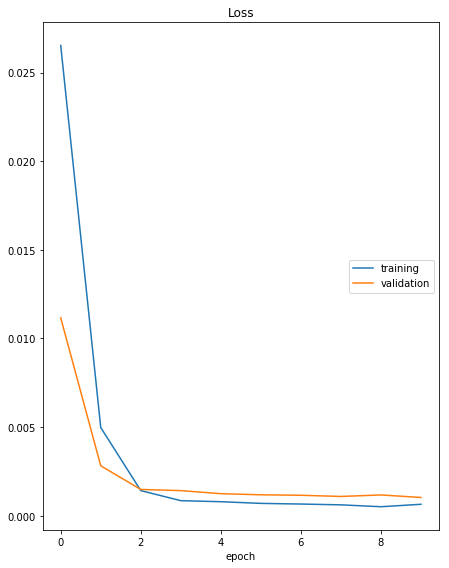

Loss
	training         	 (min:    0.001, max:    0.027, cur:    0.001)
	validation       	 (min:    0.001, max:    0.011, cur:    0.001)
18/18 [==============================] - 90s 5s/step - loss: 6.4563e-04 - val_loss: 0.0010


In [15]:
vgg_history = vgg16_model_ft.fit(training_data, 
                            training_bb, 
                            validation_data=(validation_data, validation_bb),
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_2, early_stop, plot_loss_2],
                            verbose=1)  

In [14]:
vgg16_model_ft.load_weights('det_model_v2.weights.best.vgg16') 

preds = vgg16_model_ft.predict(test_data)
results['Modelo'].append('VGG16-Adam(lr = 0.0001)-mse-ft4')

mse = mean_squared_error(test_bb,preds)
results['MSE'].append(mse)
print("MSE: ",mse)

mae = mean_absolute_error(test_bb,preds)
results['MAE'].append(mae)
print("MAE: ",mae)

mape = mean_absolute_percentage_error(test_bb,preds)
results['MAPE'].append(mape)
print("MAPE: ",mape)

rmse = mean_squared_error(test_bb,preds, squared=False)
results['RMSE'].append(rmse)
print("RMSE: ",rmse)

area_caja_real = (test_bb[:,1] - test_bb[:,0]) * (test_bb[:,3] - test_bb[:,2])
area_caja_predicha = (preds[:,1] - preds[:,0]) * (preds[:,3] - preds[:,2])

xA = np.array([max(p,r) for p,r in zip(preds[:,0], test_bb[:,0])])
yA = np.array([max(p,r) for p,r in zip(preds[:,2], test_bb[:,2])])

xB = np.array([min(p,r) for p,r in zip(preds[:,1], test_bb[:,1])])
yB = np.array([min(p,r) for p,r in zip(preds[:,3], test_bb[:,3])])

interArea = (xB - xA) * (yB - yA)
iou = interArea/(area_caja_real+area_caja_predicha-interArea)
results['Mean IOU'].append(np.mean(iou))
print('Mean Intersection over Union: ', np.mean(iou))

MSE:  0.0012986509
MAE:  0.022347022
MAPE:  0.077229924
RMSE:  0.029987935
Mean Intersection over Union:  0.8737506


Tercera configuración: Adam con lr = 0.00001, MSE como función de pérdida y entrenando el último bloque convolucional del modelo VGG16.

In [16]:
optim_2 =  tf.keras.optimizers.Adam(learning_rate=0.00001)

vgg16_model_ft2 = create_model(input_shape, optim_2, criterion1, fine_tune=4)

In [17]:
plot_loss_3 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_3 = ModelCheckpoint(filepath='det_model_v3.weights.best.vgg16',
                                  save_best_only=True,
                                  verbose=1)


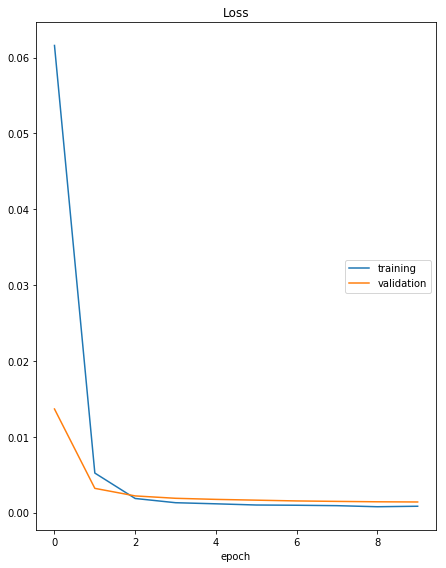

Loss
	training         	 (min:    0.001, max:    0.062, cur:    0.001)
	validation       	 (min:    0.001, max:    0.014, cur:    0.001)
18/18 [==============================] - 90s 5s/step - loss: 8.4887e-04 - val_loss: 0.0014


In [18]:
vgg_history = vgg16_model_ft2.fit(training_data, 
                            training_bb, 
                            validation_data=(validation_data, validation_bb),
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_3, early_stop, plot_loss_3],
                            verbose=1)  

In [19]:
vgg16_model_ft2.load_weights('det_model_v3.weights.best.vgg16') 

preds = vgg16_model_ft2.predict(test_data)
results['Modelo'].append('VGG16-Adam(lr = 0.00001)-mse-ft4')

mse = mean_squared_error(test_bb,preds)
results['MSE'].append(mse)
print("MSE: ",mse)

mae = mean_absolute_error(test_bb,preds)
results['MAE'].append(mae)
print("MAE: ",mae)

mape = mean_absolute_percentage_error(test_bb,preds)
results['MAPE'].append(mape)
print("MAPE: ",mape)

rmse = mean_squared_error(test_bb,preds, squared=False)
results['RMSE'].append(rmse)
print("RMSE: ",rmse)

area_caja_real = (test_bb[:,1] - test_bb[:,0]) * (test_bb[:,3] - test_bb[:,2])
area_caja_predicha = (preds[:,1] - preds[:,0]) * (preds[:,3] - preds[:,2])

xA = np.array([max(p,r) for p,r in zip(preds[:,0], test_bb[:,0])])
yA = np.array([max(p,r) for p,r in zip(preds[:,2], test_bb[:,2])])

xB = np.array([min(p,r) for p,r in zip(preds[:,1], test_bb[:,1])])
yB = np.array([min(p,r) for p,r in zip(preds[:,3], test_bb[:,3])])

interArea = (xB - xA) * (yB - yA)
iou = interArea/(area_caja_real+area_caja_predicha-interArea)
results['Mean IOU'].append(np.mean(iou))
print('Mean Intersection over Union: ', np.mean(iou))

MSE:  0.0018390805
MAE:  0.030117061
MAPE:  0.10465421
RMSE:  0.038406994
Mean Intersection over Union:  0.8383378


Cuarta configuración: Adam con lr = 0.0001, MAE como función de pérdida y sin fine-tuning (todas las capas del modelo salvo las que hemos definido congeladas).

In [20]:
criterion2 = 'mae'
vgg16_model_ft3 = create_model(input_shape, optim_1, criterion2, fine_tune=0)

In [21]:
plot_loss_4 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_4 = ModelCheckpoint(filepath='det_model_v4.weights.best.vgg16',
                                  save_best_only=True,
                                  verbose=1)


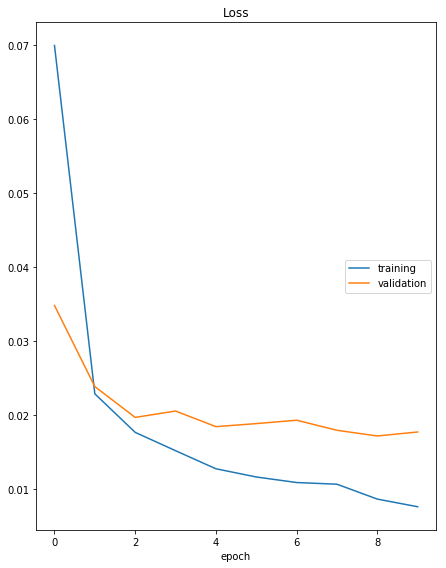

Loss
	training         	 (min:    0.008, max:    0.070, cur:    0.008)
	validation       	 (min:    0.017, max:    0.035, cur:    0.018)
18/18 [==============================] - 73s 4s/step - loss: 0.0076 - val_loss: 0.0177


In [22]:
vgg_history = vgg16_model_ft3.fit(training_data, 
                            training_bb, 
                            validation_data=(validation_data, validation_bb),
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_4, early_stop, plot_loss_4],
                            verbose=1)  

In [23]:
vgg16_model_ft3.load_weights('det_model_v4.weights.best.vgg16') 

preds = vgg16_model_ft3.predict(test_data)
results['Modelo'].append('VGG16-Adam(lr = 0.0001)-mae-ft0')

mse = mean_squared_error(test_bb,preds)
results['MSE'].append(mse)
print("MSE: ",mse)

mae = mean_absolute_error(test_bb,preds)
results['MAE'].append(mae)
print("MAE: ",mae)

mape = mean_absolute_percentage_error(test_bb,preds)
results['MAPE'].append(mape)
print("MAPE: ",mape)

rmse = mean_squared_error(test_bb,preds, squared=False)
results['RMSE'].append(rmse)
print("RMSE: ",rmse)

area_caja_real = (test_bb[:,1] - test_bb[:,0]) * (test_bb[:,3] - test_bb[:,2])
area_caja_predicha = (preds[:,1] - preds[:,0]) * (preds[:,3] - preds[:,2])

xA = np.array([max(p,r) for p,r in zip(preds[:,0], test_bb[:,0])])
yA = np.array([max(p,r) for p,r in zip(preds[:,2], test_bb[:,2])])

xB = np.array([min(p,r) for p,r in zip(preds[:,1], test_bb[:,1])])
yB = np.array([min(p,r) for p,r in zip(preds[:,3], test_bb[:,3])])

interArea = (xB - xA) * (yB - yA)
iou = interArea/(area_caja_real+area_caja_predicha-interArea)
results['Mean IOU'].append(np.mean(iou))
print('Mean Intersection over Union: ', np.mean(iou))

MSE:  0.00091046793
MAE:  0.019557225
MAPE:  0.07307458
RMSE:  0.026128663
Mean Intersection over Union:  0.8880096


In [24]:
results

{'Modelo': ['VGG16-Adam(lr = 0.0001)-mse-ft0',
  'VGG16-Adam(lr = 0.0001)-mse-ft4',
  'VGG16-Adam(lr = 0.00001)-mse-ft4',
  'VGG16-Adam(lr = 0.0001)-mae-ft0'],
 'MSE': [0.000931419, 0.0012986509, 0.0018390805, 0.00091046793],
 'MAE': [0.020630354, 0.022347022, 0.030117061, 0.019557225],
 'MAPE': [0.07886897, 0.077229924, 0.10465421, 0.07307458],
 'RMSE': [0.026779443, 0.029987935, 0.038406994, 0.026128663],
 'Mean IOU': [0.8833844, 0.8737506, 0.8383378, 0.8880096]}

Quinta configuración: RMSprop con lr = 0.0001, MAE como función de pérdida y sin fine-tuning (todas las capas del modelo salvo las que hemos definido congeladas).

In [28]:
optim_3 =  tf.keras.optimizers.RMSprop(learning_rate=0.0001)

vgg16_model_ft4 = create_model(input_shape, optim_3, criterion2, fine_tune=0)

In [29]:
plot_loss_5 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_5 = ModelCheckpoint(filepath='det_model_v5.weights.best.vgg16',
                                  save_best_only=True,
                                  verbose=1)


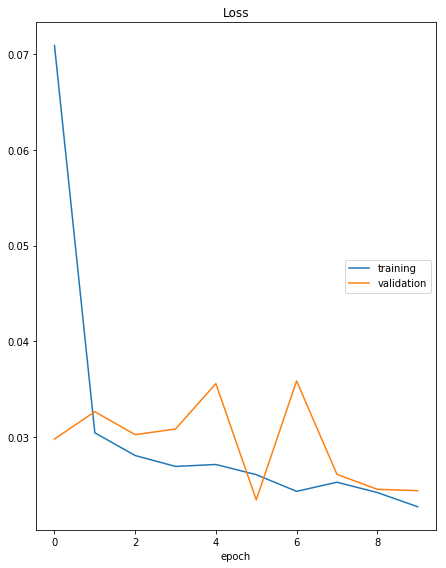

Loss
	training         	 (min:    0.023, max:    0.071, cur:    0.023)
	validation       	 (min:    0.023, max:    0.036, cur:    0.024)
18/18 [==============================] - 72s 4s/step - loss: 0.0227 - val_loss: 0.0244


In [30]:
vgg_history = vgg16_model_ft4.fit(training_data, 
                            training_bb, 
                            validation_data=(validation_data, validation_bb),
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_5, early_stop, plot_loss_5],
                            verbose=1)  

In [31]:
vgg16_model_ft4.load_weights('det_model_v5.weights.best.vgg16') 

preds = vgg16_model_ft4.predict(test_data)
results['Modelo'].append('VGG16-RMSprop(lr = 0.0001)-mae-ft0')

mse = mean_squared_error(test_bb,preds)
results['MSE'].append(mse)
print("MSE: ",mse)

mae = mean_absolute_error(test_bb,preds)
results['MAE'].append(mae)
print("MAE: ",mae)

mape = mean_absolute_percentage_error(test_bb,preds)
results['MAPE'].append(mape)
print("MAPE: ",mape)

rmse = mean_squared_error(test_bb,preds, squared=False)
results['RMSE'].append(rmse)
print("RMSE: ",rmse)

area_caja_real = (test_bb[:,1] - test_bb[:,0]) * (test_bb[:,3] - test_bb[:,2])
area_caja_predicha = (preds[:,1] - preds[:,0]) * (preds[:,3] - preds[:,2])

xA = np.array([max(p,r) for p,r in zip(preds[:,0], test_bb[:,0])])
yA = np.array([max(p,r) for p,r in zip(preds[:,2], test_bb[:,2])])

xB = np.array([min(p,r) for p,r in zip(preds[:,1], test_bb[:,1])])
yB = np.array([min(p,r) for p,r in zip(preds[:,3], test_bb[:,3])])

interArea = (xB - xA) * (yB - yA)
iou = interArea/(area_caja_real+area_caja_predicha-interArea)
results['Mean IOU'].append(np.mean(iou))
print('Mean Intersection over Union: ', np.mean(iou))

MSE:  0.0019840351
MAE:  0.027923828
MAPE:  0.10678909
RMSE:  0.036059305
Mean Intersection over Union:  0.8467457


In [32]:
results

{'Modelo': ['VGG16-Adam(lr = 0.0001)-mse-ft0',
  'VGG16-Adam(lr = 0.0001)-mse-ft4',
  'VGG16-Adam(lr = 0.00001)-mse-ft4',
  'VGG16-Adam(lr = 0.0001)-mae-ft0',
  'VGG16-RMSprop(lr = 0.0001)-mae-ft0'],
 'MSE': [0.000931419, 0.0012986509, 0.0018390805, 0.00091046793, 0.0019840351],
 'MAE': [0.020630354, 0.022347022, 0.030117061, 0.019557225, 0.027923828],
 'MAPE': [0.07886897, 0.077229924, 0.10465421, 0.07307458, 0.10678909],
 'RMSE': [0.026779443, 0.029987935, 0.038406994, 0.026128663, 0.036059305],
 'Mean IOU': [0.8833844, 0.8737506, 0.8383378, 0.8880096, 0.8467457]}

Sexta configuración: RMSprop con lr = 0.00001, MAE como función de pérdida y entrenando el último bloque convolucional del modelo VGG16.

In [33]:
optim_4 =  tf.keras.optimizers.RMSprop(learning_rate=0.00001)

vgg16_model_ft5 = create_model(input_shape, optim_4, criterion2, fine_tune=4)

In [34]:
plot_loss_6 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_6 = ModelCheckpoint(filepath='det_model_v6.weights.best.vgg16',
                                  save_best_only=True,
                                  verbose=1)


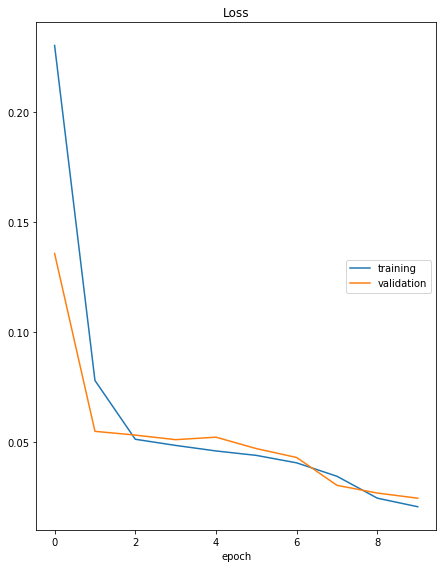

Loss
	training         	 (min:    0.021, max:    0.230, cur:    0.021)
	validation       	 (min:    0.024, max:    0.136, cur:    0.024)
18/18 [==============================] - 93s 5s/step - loss: 0.0205 - val_loss: 0.0244


In [35]:
vgg_history = vgg16_model_ft5.fit(training_data, 
                            training_bb, 
                            validation_data=(validation_data, validation_bb),
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_6, early_stop, plot_loss_6],
                            verbose=1)  

In [36]:
vgg16_model_ft5.load_weights('det_model_v6.weights.best.vgg16') 

preds = vgg16_model_ft5.predict(test_data)
results['Modelo'].append('VGG16-RMSprop(lr = 0.00001)-mae-ft4')

mse = mean_squared_error(test_bb,preds)
results['MSE'].append(mse)
print("MSE: ",mse)

mae = mean_absolute_error(test_bb,preds)
results['MAE'].append(mae)
print("MAE: ",mae)

mape = mean_absolute_percentage_error(test_bb,preds)
results['MAPE'].append(mape)
print("MAPE: ",mape)

rmse = mean_squared_error(test_bb,preds, squared=False)
results['RMSE'].append(rmse)
print("RMSE: ",rmse)

area_caja_real = (test_bb[:,1] - test_bb[:,0]) * (test_bb[:,3] - test_bb[:,2])
area_caja_predicha = (preds[:,1] - preds[:,0]) * (preds[:,3] - preds[:,2])

xA = np.array([max(p,r) for p,r in zip(preds[:,0], test_bb[:,0])])
yA = np.array([max(p,r) for p,r in zip(preds[:,2], test_bb[:,2])])

xB = np.array([min(p,r) for p,r in zip(preds[:,1], test_bb[:,1])])
yB = np.array([min(p,r) for p,r in zip(preds[:,3], test_bb[:,3])])

interArea = (xB - xA) * (yB - yA)
iou = interArea/(area_caja_real+area_caja_predicha-interArea)
results['Mean IOU'].append(np.mean(iou))
print('Mean Intersection over Union: ', np.mean(iou))

MSE:  0.0014718573
MAE:  0.027403245
MAPE:  0.097951196
RMSE:  0.0359934
Mean Intersection over Union:  0.85110784


Séptima configuración: Adam con lr = 0.001, MAPE como función de pérdida y sin fine-tuning (todas las capas del modelo salvo las que hemos definido congeladas).

In [40]:
optim_5 =  tf.keras.optimizers.Adam(learning_rate=0.001)
criterion3 = 'mape'

vgg16_model_ft6 = create_model(input_shape, optim_5, criterion3, fine_tune=0)

In [41]:
plot_loss_7 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_7 = ModelCheckpoint(filepath='det_model_v7.weights.best.vgg16',
                                  save_best_only=True,
                                  verbose=1)


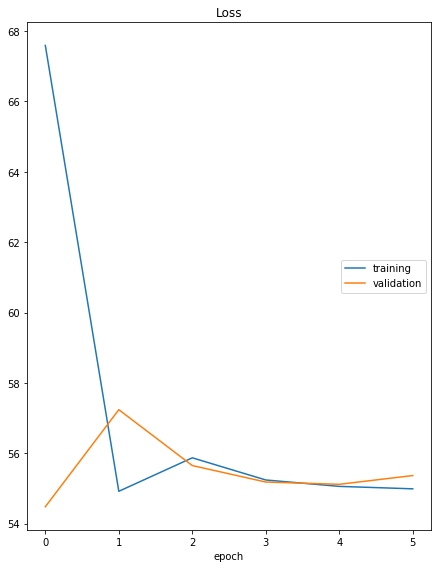

Loss
	training         	 (min:   54.918, max:   67.593, cur:   54.989)
	validation       	 (min:   54.479, max:   57.238, cur:   55.366)
18/18 [==============================] - 73s 4s/step - loss: 54.9886 - val_loss: 55.3659


In [42]:
vgg_history = vgg16_model_ft6.fit(training_data, 
                            training_bb, 
                            validation_data=(validation_data, validation_bb),
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_7, early_stop, plot_loss_7],
                            verbose=1)  

In [43]:
vgg16_model_ft6.load_weights('det_model_v7.weights.best.vgg16') 

preds = vgg16_model_ft6.predict(test_data)
results['Modelo'].append('VGG16-Adam(lr = 0.001)-mape-ft0')

mse = mean_squared_error(test_bb,preds)
results['MSE'].append(mse)
print("MSE: ",mse)

mae = mean_absolute_error(test_bb,preds)
results['MAE'].append(mae)
print("MAE: ",mae)

mape = mean_absolute_percentage_error(test_bb,preds)
results['MAPE'].append(mape)
print("MAPE: ",mape)

rmse = mean_squared_error(test_bb,preds, squared=False)
results['RMSE'].append(rmse)
print("RMSE: ",rmse)

area_caja_real = (test_bb[:,1] - test_bb[:,0]) * (test_bb[:,3] - test_bb[:,2])
area_caja_predicha = (preds[:,1] - preds[:,0]) * (preds[:,3] - preds[:,2])

xA = np.array([max(p,r) for p,r in zip(preds[:,0], test_bb[:,0])])
yA = np.array([max(p,r) for p,r in zip(preds[:,2], test_bb[:,2])])

xB = np.array([min(p,r) for p,r in zip(preds[:,1], test_bb[:,1])])
yB = np.array([min(p,r) for p,r in zip(preds[:,3], test_bb[:,3])])

interArea = (xB - xA) * (yB - yA)
iou = interArea/(area_caja_real+area_caja_predicha-interArea)
results['Mean IOU'].append(np.mean(iou))
print('Mean Intersection over Union: ', np.mean(iou))

MSE:  0.02585823
MAE:  0.1553438
MAPE:  0.55123216
RMSE:  0.1591954
Mean Intersection over Union:  0.46678463


### Resnet-50

Ahora usamos la arquitectura de Resnet-50 para aplicar el transfer learning y crear unas capas densas para detectar los limites de la caja de inclusión mínima.

In [51]:
def create_resnet50_model(input_shape, optimizer, loss_criterion, fine_tune=0):
    """
    Compila un modelo entrenado con las capas de Resnet-50
    
    input_shape: tupla - tamaño de las imágenes de entrada en forma (width, height, channels)
    optimizer: string - optimizador a utilizar en el entrenamiento para la actualización de pesos en el proceso de backpropagation'
    loss_criterion: string - función de pérdida para medir el rendimiento de la red
    fine_tune: int - Número de capas del modelo preentrenado a entrenar.
                Si es 0, todas las capas preentrenadas se 'congelan' en el entrenamiento
    """
    
    # Las capas preentrenadas utilizan en este caso pesos del dataset de imagenet.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    model_pre = keras.applications.ResNet50(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in model_pre.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in model_pre.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = model_pre.output
    x = keras.layers.Flatten()(top_model)
    x = keras.layers.Dense(128, activation="relu")(x)
    x = keras.layers.Dense(64, activation="relu")(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    output_layer = keras.layers.Dense(4, activation="sigmoid")(x)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=model_pre.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss=loss_criterion)
    
    return model

Primera configuración: Adam con lr = 0.0001, MSE como función de pérdida y sin fine-tuning (todas las capas del modelo salvo las que hemos definido congeladas).

In [52]:
optim_1 =  tf.keras.optimizers.Adam(learning_rate=0.0001)
criterion1 = 'mse'
input_shape = (224, 224, 3)

resnet50_model = create_resnet50_model(input_shape, optim_1, criterion1, fine_tune=0)

In [53]:
resnet50_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_10[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [54]:
plot_loss_8 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_8 = ModelCheckpoint(filepath='det_model_v1.weights.best.resnet50',
                                  save_best_only=True,
                                  verbose=1)


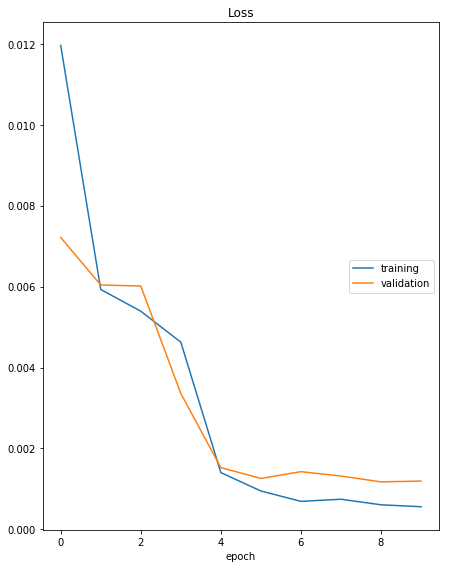

Loss
	training         	 (min:    0.001, max:    0.012, cur:    0.001)
	validation       	 (min:    0.001, max:    0.007, cur:    0.001)
18/18 [==============================] - 66s 4s/step - loss: 5.5909e-04 - val_loss: 0.0012


In [55]:
resnet50_history = resnet50_model.fit(training_data, 
                            training_bb, 
                            validation_data=(validation_data, validation_bb),
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_8, early_stop, plot_loss_8],
                            verbose=1)  

In [60]:
resnet50_model.load_weights('det_model_v1.weights.best.resnet50') 

preds = resnet50_model.predict(test_data)
results['Modelo'].append('Resnet50-Adam(lr = 0.0001)-mse-ft0')

mse = mean_squared_error(test_bb,preds)
results['MSE'].append(mse)
print("MSE: ",mse)

mae = mean_absolute_error(test_bb,preds)
results['MAE'].append(mae)
print("MAE: ",mae)

mape = mean_absolute_percentage_error(test_bb,preds)
results['MAPE'].append(mape)
print("MAPE: ",mape)

rmse = mean_squared_error(test_bb,preds, squared=False)
results['RMSE'].append(rmse)
print("RMSE: ",rmse)

area_caja_real = (test_bb[:,1] - test_bb[:,0]) * (test_bb[:,3] - test_bb[:,2])
area_caja_predicha = (preds[:,1] - preds[:,0]) * (preds[:,3] - preds[:,2])

xA = np.array([max(p,r) for p,r in zip(preds[:,0], test_bb[:,0])])
yA = np.array([max(p,r) for p,r in zip(preds[:,2], test_bb[:,2])])

xB = np.array([min(p,r) for p,r in zip(preds[:,1], test_bb[:,1])])
yB = np.array([min(p,r) for p,r in zip(preds[:,3], test_bb[:,3])])

interArea = (xB - xA) * (yB - yA)
iou = interArea/(area_caja_real+area_caja_predicha-interArea)
results['Mean IOU'].append(np.mean(iou))
print('Mean Intersection over Union: ', np.mean(iou))

MSE:  0.0016071833
MAE:  0.026296495
MAPE:  0.094205126
RMSE:  0.034415886
Mean Intersection over Union:  0.85576224


Segunda configuración: Adam con lr = 0.00001, MSE como función de pérdida y con el último bloque convolucional entrenado (10 últimas capas).

In [56]:
optim_2 =  tf.keras.optimizers.Adam(learning_rate=0.00001)
resnet50_model_ft = create_resnet50_model(input_shape, optim_2, criterion1, fine_tune=10)

In [57]:
plot_loss_9 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_9 = ModelCheckpoint(filepath='det_model_v2.weights.best.resnet50',
                                  save_best_only=True,
                                  verbose=1)


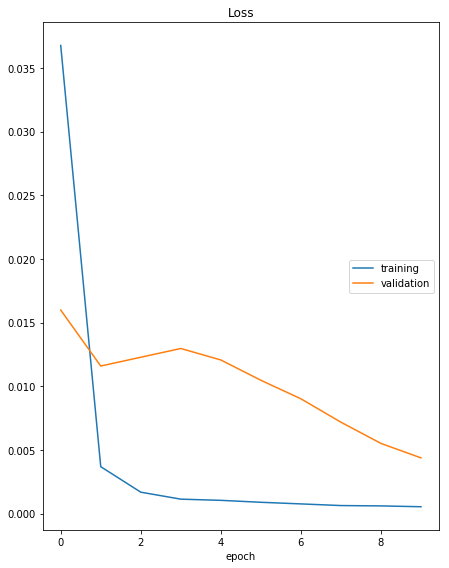

Loss
	training         	 (min:    0.001, max:    0.037, cur:    0.001)
	validation       	 (min:    0.004, max:    0.016, cur:    0.004)
18/18 [==============================] - 112s 6s/step - loss: 5.3156e-04 - val_loss: 0.0044


In [58]:
resnet50_history = resnet50_model_ft.fit(training_data, 
                            training_bb, 
                            validation_data=(validation_data, validation_bb),
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_9, early_stop, plot_loss_9],
                            verbose=1)  

In [59]:
resnet50_model_ft.load_weights('det_model_v2.weights.best.resnet50') 

preds = resnet50_model_ft.predict(test_data)
results['Modelo'].append('Resnet50-Adam(lr = 0.00001)-mse-ft10')

mse = mean_squared_error(test_bb,preds)
results['MSE'].append(mse)
print("MSE: ",mse)

mae = mean_absolute_error(test_bb,preds)
results['MAE'].append(mae)
print("MAE: ",mae)

mape = mean_absolute_percentage_error(test_bb,preds)
results['MAPE'].append(mape)
print("MAPE: ",mape)

rmse = mean_squared_error(test_bb,preds, squared=False)
results['RMSE'].append(rmse)
print("RMSE: ",rmse)

area_caja_real = (test_bb[:,1] - test_bb[:,0]) * (test_bb[:,3] - test_bb[:,2])
area_caja_predicha = (preds[:,1] - preds[:,0]) * (preds[:,3] - preds[:,2])

xA = np.array([max(p,r) for p,r in zip(preds[:,0], test_bb[:,0])])
yA = np.array([max(p,r) for p,r in zip(preds[:,2], test_bb[:,2])])

xB = np.array([min(p,r) for p,r in zip(preds[:,1], test_bb[:,1])])
yB = np.array([min(p,r) for p,r in zip(preds[:,3], test_bb[:,3])])

interArea = (xB - xA) * (yB - yA)
iou = interArea/(area_caja_real+area_caja_predicha-interArea)
results['Mean IOU'].append(np.mean(iou))
print('Mean Intersection over Union: ', np.mean(iou))

MSE:  0.005286226
MAE:  0.05660583
MAPE:  0.2512924
RMSE:  0.06694298
Mean Intersection over Union:  0.7195846


Tercera configuración: SGD con lr = 0.0001, MAE como función de pérdida y sin fine-tuning (todas las capas del modelo salvo las que hemos definido congeladas).

In [61]:
optim_3 =  tf.keras.optimizers.SGD(learning_rate=0.0001)
criterion2 = 'mae'

resnet50_model_ft2 = create_resnet50_model(input_shape, optim_3, criterion2, fine_tune=0)

In [62]:
plot_loss_10 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_10 = ModelCheckpoint(filepath='det_model_v3.weights.best.resnet50',
                                  save_best_only=True,
                                  verbose=1)


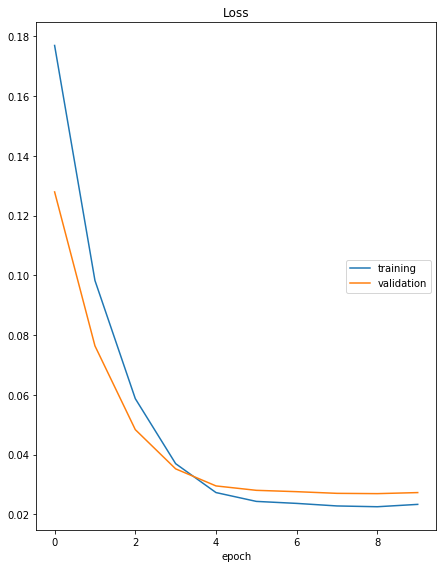

Loss
	training         	 (min:    0.023, max:    0.177, cur:    0.023)
	validation       	 (min:    0.027, max:    0.128, cur:    0.027)
18/18 [==============================] - 88s 5s/step - loss: 0.0233 - val_loss: 0.0273


In [63]:
resnet50_history = resnet50_model_ft2.fit(training_data, 
                            training_bb, 
                            validation_data=(validation_data, validation_bb),
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_10, early_stop, plot_loss_10],
                            verbose=1)  

In [64]:
resnet50_model_ft2.load_weights('det_model_v3.weights.best.resnet50') 

preds = resnet50_model_ft2.predict(test_data)
results['Modelo'].append('Resnet50-SGD(lr = 0.0001)-mae-ft0')

mse = mean_squared_error(test_bb,preds)
results['MSE'].append(mse)
print("MSE: ",mse)

mae = mean_absolute_error(test_bb,preds)
results['MAE'].append(mae)
print("MAE: ",mae)

mape = mean_absolute_percentage_error(test_bb,preds)
results['MAPE'].append(mape)
print("MAPE: ",mape)

rmse = mean_squared_error(test_bb,preds, squared=False)
results['RMSE'].append(rmse)
print("RMSE: ",rmse)

area_caja_real = (test_bb[:,1] - test_bb[:,0]) * (test_bb[:,3] - test_bb[:,2])
area_caja_predicha = (preds[:,1] - preds[:,0]) * (preds[:,3] - preds[:,2])

xA = np.array([max(p,r) for p,r in zip(preds[:,0], test_bb[:,0])])
yA = np.array([max(p,r) for p,r in zip(preds[:,2], test_bb[:,2])])

xB = np.array([min(p,r) for p,r in zip(preds[:,1], test_bb[:,1])])
yB = np.array([min(p,r) for p,r in zip(preds[:,3], test_bb[:,3])])

interArea = (xB - xA) * (yB - yA)
iou = interArea/(area_caja_real+area_caja_predicha-interArea)
results['Mean IOU'].append(np.mean(iou))
print('Mean Intersection over Union: ', np.mean(iou))

MSE:  0.0029265075
MAE:  0.035261076
MAPE:  0.121205226
RMSE:  0.045525696
Mean Intersection over Union:  0.8150439


Cuarta configuración: SGD con lr = 0.0001, MAE como función de pérdida y con el último bloque convolucional entrenado (10 últimas capas).

In [66]:
resnet50_model_ft3 = create_resnet50_model(input_shape, optim_3, criterion2, fine_tune=10)

In [67]:
plot_loss_11 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_11 = ModelCheckpoint(filepath='det_model_v4.weights.best.resnet50',
                                  save_best_only=True,
                                  verbose=1)


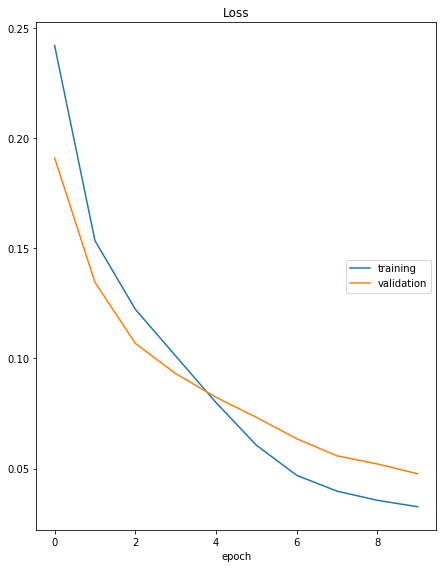

Loss
	training         	 (min:    0.033, max:    0.242, cur:    0.033)
	validation       	 (min:    0.048, max:    0.191, cur:    0.048)
18/18 [==============================] - 116s 7s/step - loss: 0.0327 - val_loss: 0.0476


In [68]:
resnet50_history = resnet50_model_ft3.fit(training_data, 
                            training_bb, 
                            validation_data=(validation_data, validation_bb),
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_11, early_stop, plot_loss_11],
                            verbose=1)  

In [69]:
resnet50_model_ft3.load_weights('det_model_v4.weights.best.resnet50') 

preds = resnet50_model_ft3.predict(test_data)
results['Modelo'].append('Resnet50-SGD(lr = 0.0001)-mae-ft10')

mse = mean_squared_error(test_bb,preds)
results['MSE'].append(mse)
print("MSE: ",mse)

mae = mean_absolute_error(test_bb,preds)
results['MAE'].append(mae)
print("MAE: ",mae)

mape = mean_absolute_percentage_error(test_bb,preds)
results['MAPE'].append(mape)
print("MAPE: ",mape)

rmse = mean_squared_error(test_bb,preds, squared=False)
results['RMSE'].append(rmse)
print("RMSE: ",rmse)

area_caja_real = (test_bb[:,1] - test_bb[:,0]) * (test_bb[:,3] - test_bb[:,2])
area_caja_predicha = (preds[:,1] - preds[:,0]) * (preds[:,3] - preds[:,2])

xA = np.array([max(p,r) for p,r in zip(preds[:,0], test_bb[:,0])])
yA = np.array([max(p,r) for p,r in zip(preds[:,2], test_bb[:,2])])

xB = np.array([min(p,r) for p,r in zip(preds[:,1], test_bb[:,1])])
yB = np.array([min(p,r) for p,r in zip(preds[:,3], test_bb[:,3])])

interArea = (xB - xA) * (yB - yA)
iou = interArea/(area_caja_real+area_caja_predicha-interArea)
results['Mean IOU'].append(np.mean(iou))
print('Mean Intersection over Union: ', np.mean(iou))

MSE:  0.004771511
MAE:  0.056242764
MAPE:  0.23673598
RMSE:  0.06704107
Mean Intersection over Union:  0.7239651


### Xception

Ahora usamos la arquitectura de Xception para aplicar el transfer learning y crear unas capas densas para detectar los limites de la caja de inclusión mínima.

In [71]:
def create_xception_model(input_shape, optimizer, loss_criterion, fine_tune=0):
    """
    Compila un modelo entrenado con las capas de Xception
    
    input_shape: tupla - tamaño de las imágenes de entrada en forma (width, height, channels)
    optimizer: string - optimizador a utilizar en el entrenamiento para la actualización de pesos en el proceso de backpropagation'
    loss_criterion: string - función de pérdida para medir el rendimiento de la red
    fine_tune: int - Número de capas del modelo preentrenado a entrenar.
                Si es 0, todas las capas preentrenadas se 'congelan' en el entrenamiento
    """
    
    # Las capas preentrenadas utilizan en este caso pesos del dataset de imagenet.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    model_pre = keras.applications.Xception(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in model_pre.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in model_pre.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = model_pre.output
    x = keras.layers.Flatten()(top_model)
    x = keras.layers.Dense(128, activation="relu")(x)
    x = keras.layers.Dense(64, activation="relu")(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    output_layer = keras.layers.Dense(4, activation="sigmoid")(x)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=model_pre.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss=loss_criterion)
    
    return model

Primera configuración: Adam con lr = 0.001, MSE como función de pérdida y sin fine-tuning (todas las capas del modelo salvo las que hemos definido congeladas).

In [72]:
optim_1 =  tf.keras.optimizers.Adam(learning_rate=0.001)
criterion1 = 'mse'
input_shape = (224, 224, 3)

xception_model = create_xception_model(input_shape, optim_1, criterion1, fine_tune=0)

83697664/83683744 [==============================] - 95s 1us/step


In [73]:
xception_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [74]:
plot_loss_12 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_12 = ModelCheckpoint(filepath='det_model_v1.weights.best.xception',
                                  save_best_only=True,
                                  verbose=1)


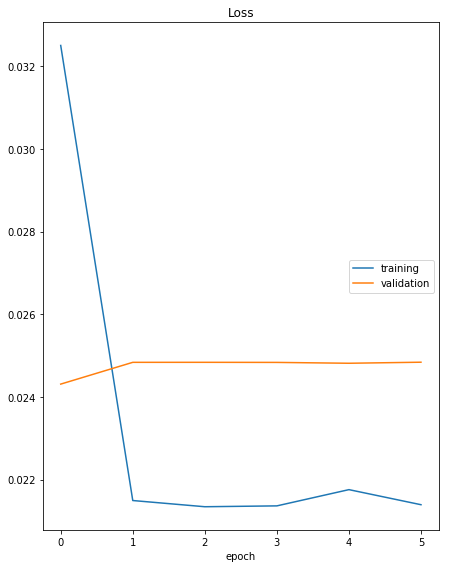

Loss
	training         	 (min:    0.021, max:    0.033, cur:    0.021)
	validation       	 (min:    0.024, max:    0.025, cur:    0.025)
18/18 [==============================] - 85s 5s/step - loss: 0.0214 - val_loss: 0.0248


In [75]:
xception_history = xception_model.fit(training_data, 
                            training_bb, 
                            validation_data=(validation_data, validation_bb),
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_12, early_stop, plot_loss_12],
                            verbose=1)  

In [76]:
xception_model.load_weights('det_model_v1.weights.best.xception') 

preds = xception_model.predict(test_data)
results['Modelo'].append('Xception-Adam(lr = 0.001)-mse-ft0')

mse = mean_squared_error(test_bb,preds)
results['MSE'].append(mse)
print("MSE: ",mse)

mae = mean_absolute_error(test_bb,preds)
results['MAE'].append(mae)
print("MAE: ",mae)

mape = mean_absolute_percentage_error(test_bb,preds)
results['MAPE'].append(mape)
print("MAPE: ",mape)

rmse = mean_squared_error(test_bb,preds, squared=False)
results['RMSE'].append(rmse)
print("RMSE: ",rmse)

area_caja_real = (test_bb[:,1] - test_bb[:,0]) * (test_bb[:,3] - test_bb[:,2])
area_caja_predicha = (preds[:,1] - preds[:,0]) * (preds[:,3] - preds[:,2])

xA = np.array([max(p,r) for p,r in zip(preds[:,0], test_bb[:,0])])
yA = np.array([max(p,r) for p,r in zip(preds[:,2], test_bb[:,2])])

xB = np.array([min(p,r) for p,r in zip(preds[:,1], test_bb[:,1])])
yB = np.array([min(p,r) for p,r in zip(preds[:,3], test_bb[:,3])])

interArea = (xB - xA) * (yB - yA)
iou = interArea/(area_caja_real+area_caja_predicha-interArea)
results['Mean IOU'].append(np.mean(iou))
print('Mean Intersection over Union: ', np.mean(iou))

MSE:  0.028371334
MAE:  0.16084576
MAPE:  0.57160866
RMSE:  0.16474178
Mean Intersection over Union:  0.4568549


Segunda configuración: Adam con lr = 0.0001, MSE como función de pérdida y entrenando el último bloque convolucional (últimas 6 capas).

In [78]:
optim_2 =  tf.keras.optimizers.Adam(learning_rate=0.0001)
input_shape = (224, 224, 3)

xception_model_ft = create_xception_model(input_shape, optim_2, criterion1, fine_tune=6)

In [79]:
plot_loss_13 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_13 = ModelCheckpoint(filepath='det_model_v2.weights.best.xception',
                                  save_best_only=True,
                                  verbose=1)


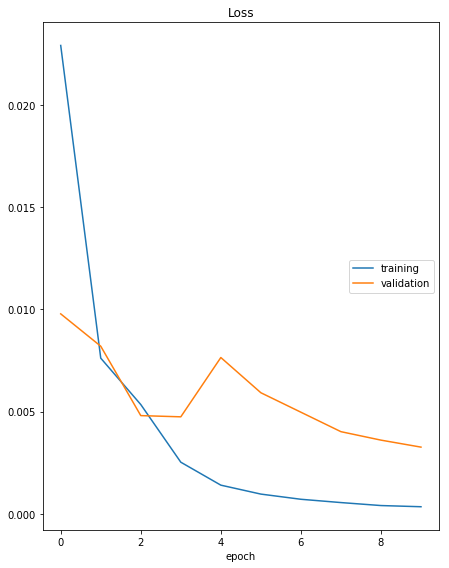

Loss
	training         	 (min:    0.000, max:    0.023, cur:    0.000)
	validation       	 (min:    0.003, max:    0.010, cur:    0.003)
18/18 [==============================] - 115s 6s/step - loss: 3.4884e-04 - val_loss: 0.0033


In [80]:
xception_history = xception_model_ft.fit(training_data, 
                            training_bb, 
                            validation_data=(validation_data, validation_bb),
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_13, early_stop, plot_loss_13],
                            verbose=1)  

In [81]:
xception_model_ft.load_weights('det_model_v2.weights.best.xception') 

preds = xception_model_ft.predict(test_data)
results['Modelo'].append('Xception-Adam(lr = 0.0001)-mse-ft6')

mse = mean_squared_error(test_bb,preds)
results['MSE'].append(mse)
print("MSE: ",mse)

mae = mean_absolute_error(test_bb,preds)
results['MAE'].append(mae)
print("MAE: ",mae)

mape = mean_absolute_percentage_error(test_bb,preds)
results['MAPE'].append(mape)
print("MAPE: ",mape)

rmse = mean_squared_error(test_bb,preds, squared=False)
results['RMSE'].append(rmse)
print("RMSE: ",rmse)

area_caja_real = (test_bb[:,1] - test_bb[:,0]) * (test_bb[:,3] - test_bb[:,2])
area_caja_predicha = (preds[:,1] - preds[:,0]) * (preds[:,3] - preds[:,2])

xA = np.array([max(p,r) for p,r in zip(preds[:,0], test_bb[:,0])])
yA = np.array([max(p,r) for p,r in zip(preds[:,2], test_bb[:,2])])

xB = np.array([min(p,r) for p,r in zip(preds[:,1], test_bb[:,1])])
yB = np.array([min(p,r) for p,r in zip(preds[:,3], test_bb[:,3])])

interArea = (xB - xA) * (yB - yA)
iou = interArea/(area_caja_real+area_caja_predicha-interArea)
results['Mean IOU'].append(np.mean(iou))
print('Mean Intersection over Union: ', np.mean(iou))

MSE:  0.0038211492
MAE:  0.05031185
MAPE:  0.17932881
RMSE:  0.05722833
Mean Intersection over Union:  0.753695


Tercera configuración: RMSprop con lr = 0.0001, mean squared logarithmic error (MSLE) como función de pérdida y entrenando el último bloque convolucional (últimas 6 capas).

In [82]:
optim_3 =  tf.keras.optimizers.RMSprop(learning_rate=0.0001)
criterion2 = 'mean_squared_logarithmic_error'
xception_model_ft2 = create_xception_model(input_shape, optim_3, criterion2, fine_tune=6)

In [83]:
plot_loss_14 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_14 = ModelCheckpoint(filepath='det_model_v3.weights.best.xception',
                                  save_best_only=True,
                                  verbose=1)


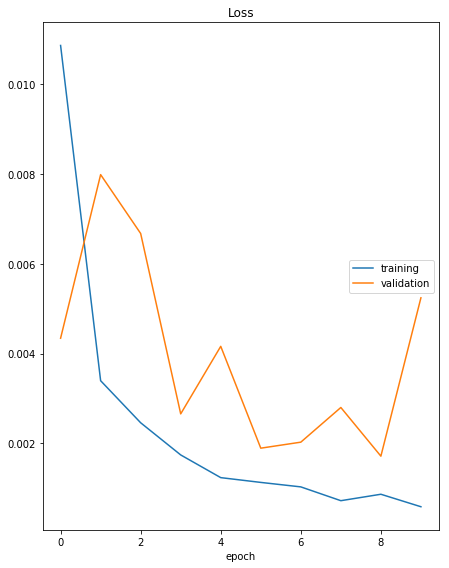

Loss
	training         	 (min:    0.001, max:    0.011, cur:    0.001)
	validation       	 (min:    0.002, max:    0.008, cur:    0.005)
18/18 [==============================] - 106s 6s/step - loss: 5.8471e-04 - val_loss: 0.0052


In [84]:
xception_history = xception_model_ft2.fit(training_data, 
                            training_bb, 
                            validation_data=(validation_data, validation_bb),
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_14, early_stop, plot_loss_14],
                            verbose=1)  

In [85]:
xception_model_ft2.load_weights('det_model_v3.weights.best.xception') 

preds = xception_model_ft2.predict(test_data)
results['Modelo'].append('Xception-RMSprop(lr = 0.0001)-msle-ft6')

mse = mean_squared_error(test_bb,preds)
results['MSE'].append(mse)
print("MSE: ",mse)

mae = mean_absolute_error(test_bb,preds)
results['MAE'].append(mae)
print("MAE: ",mae)

mape = mean_absolute_percentage_error(test_bb,preds)
results['MAPE'].append(mape)
print("MAPE: ",mape)

rmse = mean_squared_error(test_bb,preds, squared=False)
results['RMSE'].append(rmse)
print("RMSE: ",rmse)

area_caja_real = (test_bb[:,1] - test_bb[:,0]) * (test_bb[:,3] - test_bb[:,2])
area_caja_predicha = (preds[:,1] - preds[:,0]) * (preds[:,3] - preds[:,2])

xA = np.array([max(p,r) for p,r in zip(preds[:,0], test_bb[:,0])])
yA = np.array([max(p,r) for p,r in zip(preds[:,2], test_bb[:,2])])

xB = np.array([min(p,r) for p,r in zip(preds[:,1], test_bb[:,1])])
yB = np.array([min(p,r) for p,r in zip(preds[:,3], test_bb[:,3])])

interArea = (xB - xA) * (yB - yA)
iou = interArea/(area_caja_real+area_caja_predicha-interArea)
results['Mean IOU'].append(np.mean(iou))
print('Mean Intersection over Union: ', np.mean(iou))

MSE:  0.003832947
MAE:  0.05105461
MAPE:  0.17283908
RMSE:  0.058744177
Mean Intersection over Union:  0.7522244


Cuarta configuración: SGD con lr = 0.00001, mean squared logarithmic error (MSLE) como función de pérdida y entrenando el último bloque convolucional (últimas 6 capas).

In [86]:
optim_4 =  tf.keras.optimizers.SGD(learning_rate=0.00001)
xception_model_ft3 = create_xception_model(input_shape, optim_4, criterion2, fine_tune=6)

In [87]:
plot_loss_15 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_15 = ModelCheckpoint(filepath='det_model_v4.weights.best.xception',
                                  save_best_only=True,
                                  verbose=1)


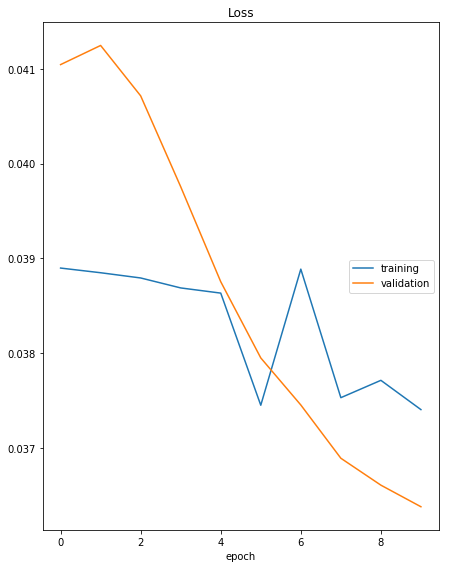

Loss
	training         	 (min:    0.037, max:    0.039, cur:    0.037)
	validation       	 (min:    0.036, max:    0.041, cur:    0.036)
18/18 [==============================] - 128s 7s/step - loss: 0.0374 - val_loss: 0.0364


In [88]:
xception_history = xception_model_ft3.fit(training_data, 
                            training_bb, 
                            validation_data=(validation_data, validation_bb),
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_15, early_stop, plot_loss_15],
                            verbose=1)  

In [89]:
xception_model_ft3.load_weights('det_model_v4.weights.best.xception') 

preds = xception_model_ft3.predict(test_data)
results['Modelo'].append('Xception-SGD(lr = 0.00001)-msle-ft6')

mse = mean_squared_error(test_bb,preds)
results['MSE'].append(mse)
print("MSE: ",mse)

mae = mean_absolute_error(test_bb,preds)
results['MAE'].append(mae)
print("MAE: ",mae)

mape = mean_absolute_percentage_error(test_bb,preds)
results['MAPE'].append(mape)
print("MAPE: ",mape)

rmse = mean_squared_error(test_bb,preds, squared=False)
results['RMSE'].append(rmse)
print("RMSE: ",rmse)

area_caja_real = (test_bb[:,1] - test_bb[:,0]) * (test_bb[:,3] - test_bb[:,2])
area_caja_predicha = (preds[:,1] - preds[:,0]) * (preds[:,3] - preds[:,2])

xA = np.array([max(p,r) for p,r in zip(preds[:,0], test_bb[:,0])])
yA = np.array([max(p,r) for p,r in zip(preds[:,2], test_bb[:,2])])

xB = np.array([min(p,r) for p,r in zip(preds[:,1], test_bb[:,1])])
yB = np.array([min(p,r) for p,r in zip(preds[:,3], test_bb[:,3])])

interArea = (xB - xA) * (yB - yA)
iou = interArea/(area_caja_real+area_caja_predicha-interArea)
results['Mean IOU'].append(np.mean(iou))
print('Mean Intersection over Union: ', np.mean(iou))

MSE:  0.076591745
MAE:  0.2617889
MAPE:  0.9016314
RMSE:  0.26796266
Mean Intersection over Union:  0.051689357


## Resultados finales

In [90]:
import pandas as pd
df_res = pd.DataFrame.from_dict(results)
df_res

,Modelo,MSE,MAE,MAPE,RMSE,Mean IOU
0,VGG16-Adam(lr = 0.0001)-mse-ft0,0.000931,0.020630,0.078869,0.026779,0.883384
1,VGG16-Adam(lr = 0.0001)-mse-ft4,0.001299,0.022347,0.077230,0.029988,0.873751
2,VGG16-Adam(lr = 0.00001)-mse-ft4,0.001839,0.030117,0.104654,0.038407,0.838338
3,VGG16-Adam(lr = 0.0001)-mae-ft0,0.000910,0.019557,0.073075,0.026129,0.888010
4,VGG16-RMSprop(lr = 0.0001)-mae-ft0,0.001984,0.027924,0.106789,0.036059,0.846746
5,VGG16-RMSprop(lr = 0.00001)-mae-ft4,0.001472,0.027403,0.097951,0.035993,0.851108
6,VGG16-Adam(lr = 0.001)-mape-ft0,0.025858,0.155344,0.551232,0.159195,0.466785
7,Resnet50-Adam(lr = 0.00001)-mse-ft10,0.005286,0.056606,0.251292,0.066943,0.719585
8,Resnet50-Adam(lr = 0.0001)-mse-ft0,0.001607,0.026296,0.094205,0.034416,0.855762
9,Resnet50-SGD(lr = 0.0001)-mae-ft0,0.002927,0.035261,0.121205,0.045526,0.815044
